In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla
import seaborn as sns


def finite_1D(xmin, xmax, Nx, Vfun, neigs):   # Solucion cristal fotonico finito.

    
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
   
    H = sparse.eye(Nx, Nx, format='lil') * (-2)    # implement the numerical derivative
    e=sparse.eye(Nx, Nx, format='lil')   # implement the numerical derivative
        
    for i in range(Nx - 1):
        H[i, i + 1] =  1
        H[i + 1, i] = 1
        e[i,i]*=V[i]**-1
    

    H = e@H/ (dx ** 2)
    H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
    [evl, evt] = sla.eigs(H, k=neigs, which='SM')
    
    
    for i in range(neigs):
        # normalize the eigenvectors:
        evt[:, i] = evt[:, i] 
        evl = np.abs((evl))

        
    return evl, evt, x

# Grafico autofunciones.

In [21]:
def eval_eigenfunc(xmin, xmax, Nx, Vfun, neigs):
   
   
    H = finite_1D(xmin, xmax, Nx, Vfun, neigs)
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)   
    evt = H[1] # eigenvectors 
    x = H[2] # x grid 
    i = 0
    plt.figure(figsize=(20,15))
    while i < neigs:
        n = indices[i]
        # obtain probabilities from wave functions
        y = np.real(np.conj(evt[:, n]) * evt[:, n]) 
        #y = np.angle( evt[:, n])

        plt.subplot(neigs, 1, i+1)  
        plt.plot(x, y)
        plt.plot(x, Vfun/max(Vfun)*max(y))
        plt.axis('off')
        i = i + 1  
    
    plt.show()
    

def eigenfunc(xmin, xmax, Nx, Vfun, neigs,paso):
    
    
    H = finite_1D(xmin, xmax, Nx, Vfun, neigs)
    lista=[]
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)   
    evt = H[1] # eigenvectors 
    x = H[2] # x grid 
    for i in range(paso-1,neigs,paso):
        
        n = indices[i] # call the 1D :
        y = np.real(np.conj(evt[:, n]) * evt[:, n]) 
        lista.append(y)

    return lista,x

def eigenfunc_phase(xmin, xmax, Nx, Vfun, neigs,paso):


    H = finite_1D(xmin, xmax, Nx, Vfun, neigs)
    lista=[]
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)   
    evt = H[1] # eigenvectors 
    x = H[2] # x grid 
    for i in range(paso-1,neigs,paso):
        
        n = indices[i]
        y = np.angle(evt[:, n])
        lista.append(y)


    return lista,x    

# Forma opcional.

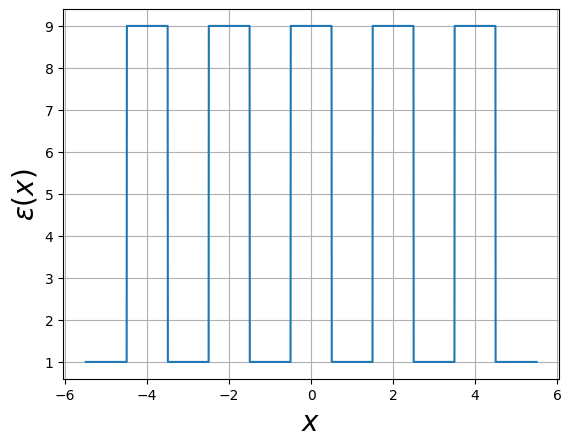

In [21]:
nx = 2048 # number of sampling points of a single unit cell
length_aire=0
er2=1.  # Dielectric value 2
er1=9.  # Dielectric value 1
d=1
aa=1 # tamaño de un rectangulo
number=5
L_finite=aa*number+aa/2#  half of the total len of the lattic
ML=int(nx)
Mrest=int(nx)

def periodicf(lid,lfd,f,x):

    
    if x>=lid and x<=lfd :
        return er1
    if ((x>=lfd and x<=(lfd+2*aa)) or (x<=lid and x>=(lid-2*aa))) :
        return f(x)
    if abs(x)>L_finite:
        return 1
    elif x>(lfd+2*aa):
        x_new=x-(2*aa)
        return periodicf(li,lf,f,x_new)
    elif x<(lid-2*aa):
        x_new=x+(2*aa)
        return periodicf(li,lf,f,x_new)
    
    
def squareP(li,lf,x):
    return periodicf(li,lf,square,x)
 
# Non-periodic square wave function defined for a range [-l,l]
def square(x):
    if abs(x)>(lf+aa):
        return er1
    else:
        return er2

li = -d/2
lf = d/2
lon=1
x_cell =np.linspace(-L_finite-length_aire,L_finite+length_aire,ML) # spatial sampling # sampling points in the unit cel
e_cell = [squareP(li,lf,xi) for xi in x_cell]#Dielectric function
plt.plot(x_cell,e_cell)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\epsilon(x)$',fontsize=20)
plt.grid()


# Forma nueva.

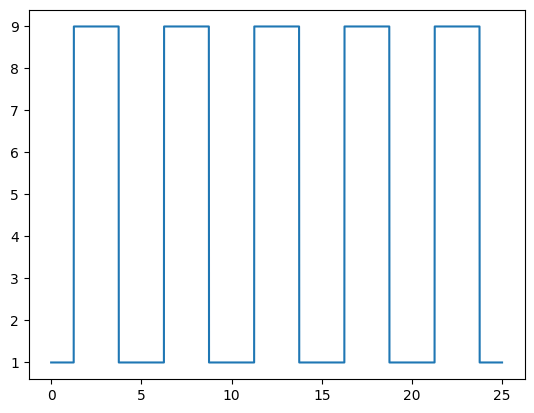

In [23]:
n = 512 # number of sampling points of a single unit cell
M = 5 # times the cell is repeated through all space
N = M*n # total number of sampling points
a0 = 1. # lattice constant
a = a0*M # lattice constant of the cristal
dx = a/N # space increment
x_cell = np.arange(0, a0, dx) # sampling points in the unit cell
e1 = 1.; e2 = 9.
e_cell = e1 + (x_cell < 0.75*a0)*(x_cell > 0.25*a0)*(e2 - e1)
x = np.arange(0, a*M, dx*M)
e = np.array(list(e_cell)*M)
kappa = np.diag(e**-1)
plt.figure()
plt.plot(x, e)
plt.show()
nx=N

# Generalización del método.

In [33]:
D0 = np.diag([-2]*N, 0) + np.diag([1]*(N-1), -1) + np.diag([1]*(N-1), 1)
#D0[0,-1] = 1.; D0[-1,0]= 1.
D0 = D0.astype("float")
D0 = kappa @ D0 * dx**-2

B0 = np.zeros((N,n), dtype='complex')
k = np.pi*a0

for m in range(M):
    B0[m*n:(m+1)*n] = np.identity(n)

Nk = 25
b = np.pi/a0
#BZ = np.linspace(-b,b,Nk)
BZ = np.arange(M)*2*np.pi/(a*M)
#BZ = [0]
band_structure = []
eigenmodes = []


for k in BZ:
    
    B = np.copy(B0)
    for m in range(M):
        B[m*n:(m+1)*n] *= np.exp(1j*k*a0*m)
    Binv = B.T.conj()
    
    D = np.copy(D0).astype("complex")
    D[0,-1] *= np.exp(-1j*M*k*a0); D[-1, 0] *= np.exp(1j*M*k*a0)
    D = Binv @ D @ B
    
    #eigenfreqs, eigenvecs = eigs(A, which='SR', k = N0)
    eigenfreqs, eigenvecs = np.linalg.eig(D)
    eigenfreqs = np.sqrt(np.abs(np.real(eigenfreqs)))
    inds = eigenfreqs.argsort()
    eigenvecs = eigenvecs[:,inds]
    eigenfreqs.sort()
    band_structure.append(eigenfreqs)
    eigenmodes.append(eigenvecs)

    
GFDFD_band_structure = np.array(band_structure)[:,:20] # keep the first 20 modes
GFDFD_eigenmodes = np.array(eigenmodes)[:,:,:20] # keep the first 20 modes

In [38]:
aaa,xxx=eigenfunc(min(x_cell), max(x_cell), nx, np.array(e),M*10,M)

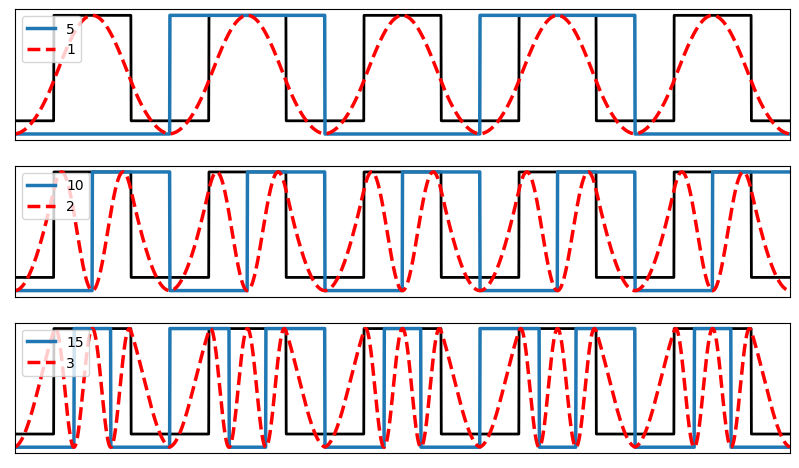

In [25]:
plt.figure(figsize=(10,20))
cc=len(aaa)
cont=0
Vfun=np.array(e)

for i in aaa[:3:]:

    plt.subplot(cc, 1, cont+1)
    plt.xticks([])
    plt.yticks([])
    field1 = np.abs(GFDFD_eigenmodes[0][:,cont])**2   
    cont+=1
    plt.plot(x,e/max(e_cell),color='black', lw=2)
    plt.plot(x, i/max(i),label=str(cont*M), lw=2.5)
    plt.plot(x,list(field1)*M/max(field1),'--r',lw=2.5,label=str(cont)) 
    plt.xlim([min(x),max(x)])
    plt.legend(loc='upper left')


In [16]:
BZ = np.linspace(-b,b,Nk)

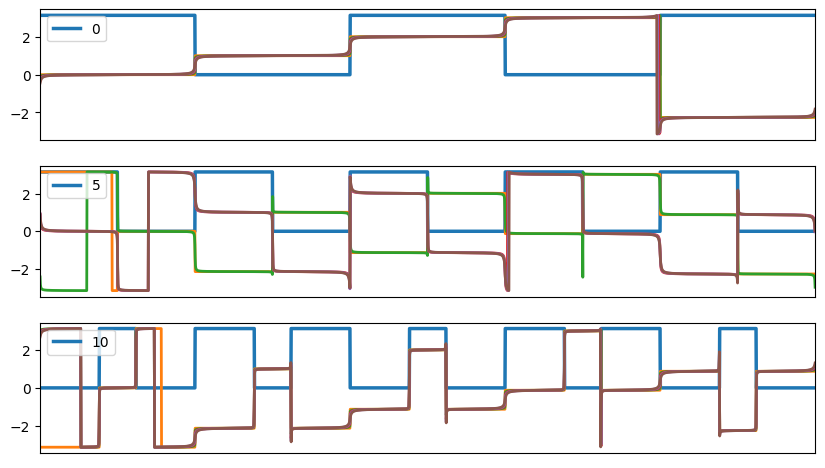

In [37]:
plt.figure(figsize=(10,20))
cc=len(aaa)
cont=0
Vfun=np.array(e)

for i in aaa[:3:]:

    plt.subplot(cc, 1, cont+1)
    plt.xticks([])
    #plt.yticks([])

    plt.plot(x, i,label=str(cont*M), lw=2.5)
    for k in range(len(BZ)):
        
        
        field1 = list(np.angle(B@GFDFD_eigenmodes[k][:,cont]))
        plt.plot(x,field1, lw=2)


    cont+=1
    #plt.plot(x,field1*M,color='black',label=str(cont), lw=2)
    #plt.plot(x, i,label=str(cont*M), lw=2.5)
    plt.xlim([min(x),max(x)])
    plt.legend(loc='upper left')


# Cristal fotonico realizado usando bloch

In [27]:
def bloch_1D(xmin, xmax, Nx, Vfun, neigs,k,ax):   
    
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
   
    H = sparse.eye(Nx, Nx, format='lil') * (-2)    # implement the numerical derivative
    e=sparse.eye(Nx, Nx, format='lil')   # implement the numerical derivative
        
    for i in range(Nx - 1):
        H[i, i + 1] =  1
        H[i + 1, i] = 1
        e[i,i]*=V[i]**-1
    
    H[0, -1] =  np.exp(-1j*k*ax)
    H[-1, 0] =  np.exp(1j*k*ax)
    H = e@H/ (dx ** 2)

       # convert to csc sparse matrix format:
    H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
    [evl, evt] = sla.eigs(H, k=neigs, which='SM')
    for i in range(neigs):
        # normalize the eigenvectors:
        evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
        # eigen values MUST be real:
        evl = np.sqrt(np.abs(np.real(evl)))   
     
    return evl, evt, x


def eval_infinite(xmin, xmax, Nx, Vfun, neigs,k,ax):
    # call the 1D :
    H = bloch_1D(xmin, xmax, Nx, Vfun, neigs,k,ax)
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)   
    evt = H[1] # eigenvectors 
    Vfun=list(Vfun)*number
    i = 0
    plt.figure(figsize=(20,15))
    
    while i < neigs:
        
        n = indices[i]
        # obtain probabilities from wave functions
        y = list(np.real(np.conj(evt[:, n]) * evt[:, n]))
        e_inf=Vfun/max(Vfun)*max(y)
        x = np.linspace(-L_finite,L_finite,len(e_inf))
        #y = np.angle( evt[:, n])
        
        plt.subplot(neigs, 1, i+1)  
        
        plt.plot(x, y*number)
        plt.plot(x, e_inf)
        plt.axis('off')
        i = i + 1  

    plt.show()
    

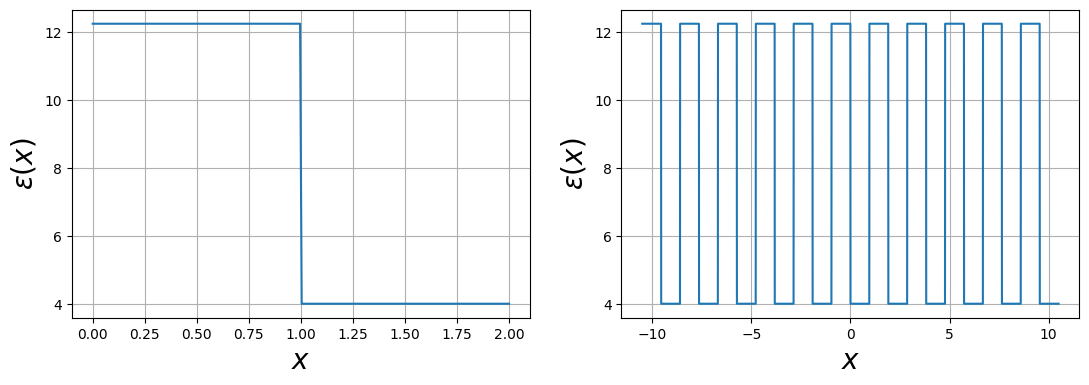

In [28]:
nx = 1048 # number of sampling points of a single unit cell
er2=4  # Dielectric value 2
er1=12.25  # Dielectric value 1
d=1
aa=1 # tamaño de un rectangulo
L=aa*2#  half of the total len of the lattic
ML=int(nx/4)
Mrest=int(nx/2)*0

# Non-periodic square wave function defined for a range [-l,l]
def square(x):
    if abs(x)<(aa):
        return er1
    else:
        return er2
lf = d
lon=1
x_cell2 =np.linspace(0,L,ML) # spatial sampling # sampling points in the unit cell
e_cell2 = [square(xi) for xi in x_cell2]
nx=len(x_cell2)
f=plt.figure(figsize=(13,4))

plt.subplot(121)
plt.plot(x_cell2,e_cell2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\epsilon(x)$',fontsize=20)
plt.grid()

plt.subplot(122)

e_infinite=e_cell2*11
x_infinite=np.linspace(-L_finite,L_finite,len(e_infinite))
plt.plot(x_infinite,e_infinite)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\epsilon(x)$',fontsize=20)
plt.grid()

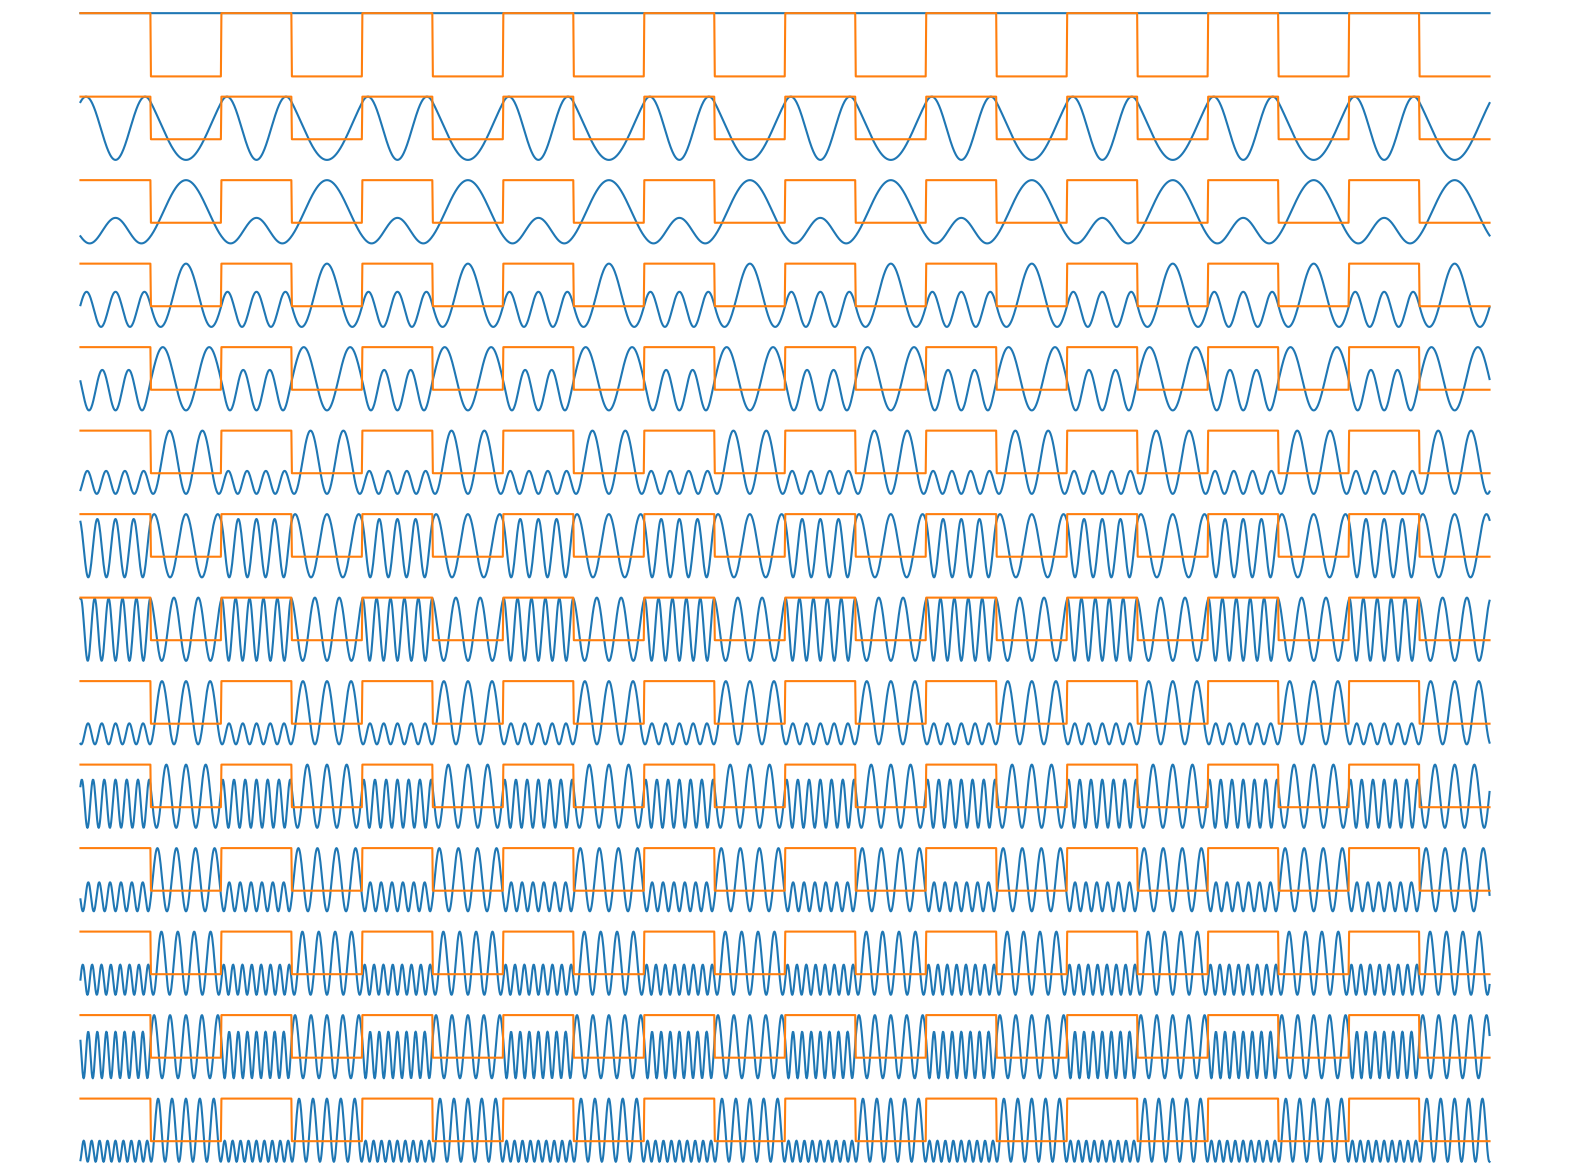

In [30]:
eval_infinite(min(x_cell2), max(x_cell2), nx, np.array(e_cell2),14,0,aa)


# Modos.

In [76]:
def evv_infinite(xmin, xmax, Nx, Vfun, neigs,ax):
    ks=np.linspace(-np.pi/ax,np.pi/ax,50)
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
    omega=np.zeros((neigs,len(ks)))
    cc=0
    for k in ks:
        H = sparse.eye(Nx, Nx,dtype=complex, format='lil') * (-2)    # implement the numerical derivative
        e=sparse.eye(Nx, Nx,dtype=complex, format='lil')   # implement the numerical derivative
            
        for i in range(Nx - 1):
            H[i, i + 1] =  1
            H[i + 1, i] = 1
            e[i,i]*=V[i]**-1
        
        H[0, -1] =  np.exp(-1j*k*ax)
        H[-1, 0] =  np.exp(1j*k*ax)

        H = e@H/ (dx ** 2)

        # convert to csc sparse matrix format:
        H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
        [evl, evt] = sla.eigs(H, k=neigs, which='SM')

        indices = np.argsort(evl)   
        w=np.sort((np.sqrt(np.abs(evl))))
        for m in range(len(w)):
            omega[m,cc]=w[m]
            
        cc+=1
    
    return omega


def ev_infinite(xmin, xmax, Nx, Vfun,neigs,ax,s):

    ks=np.linspace(-np.pi/ax,np.pi/ax,14)
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
    vect=np.zeros((len(ks),len(x)))
    cc=0
    for k in ks:
        H = sparse.eye(Nx, Nx,dtype=complex, format='lil') * (-2)    # implement the numerical derivative
        e=sparse.eye(Nx, Nx,dtype=complex, format='lil')   # implement the numerical derivative
            
        for i in range(Nx - 1):
            H[i, i + 1] =  1
            H[i + 1, i] = 1
            e[i,i]*=V[i]**-1
        
        H[0, -1] =  np.exp(-1j*k*ax)
        H[-1, 0] =  np.exp(1j*k*ax)

        H = e@H/ (dx ** 2)

        # convert to csc sparse matrix format:
        H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
        [evl, evt] = sla.eigs(H, k=neigs, which='SM')
        
        for i in range(neigs):
        # normalize the eigenvectors:
            evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
            
        evl=np.abs(evl)
    
        indices = np.argsort(evl) 
        w=np.sort((np.sqrt(np.abs(evl))))  
        vect[cc,:]=(np.real(np.conj(evt[:, indices[s]]) * evt[:, indices[s]]))
            
        cc+=1


    return vect


        
        

In [57]:
freq= evv_infinite(min(x_cell2), max(x_cell2), nx, np.array(e_cell2),14,aa)

In [108]:
vects= ev_infinite(min(x_cell2), max(x_cell2), nx, np.array(e_cell2),14,aa,3)

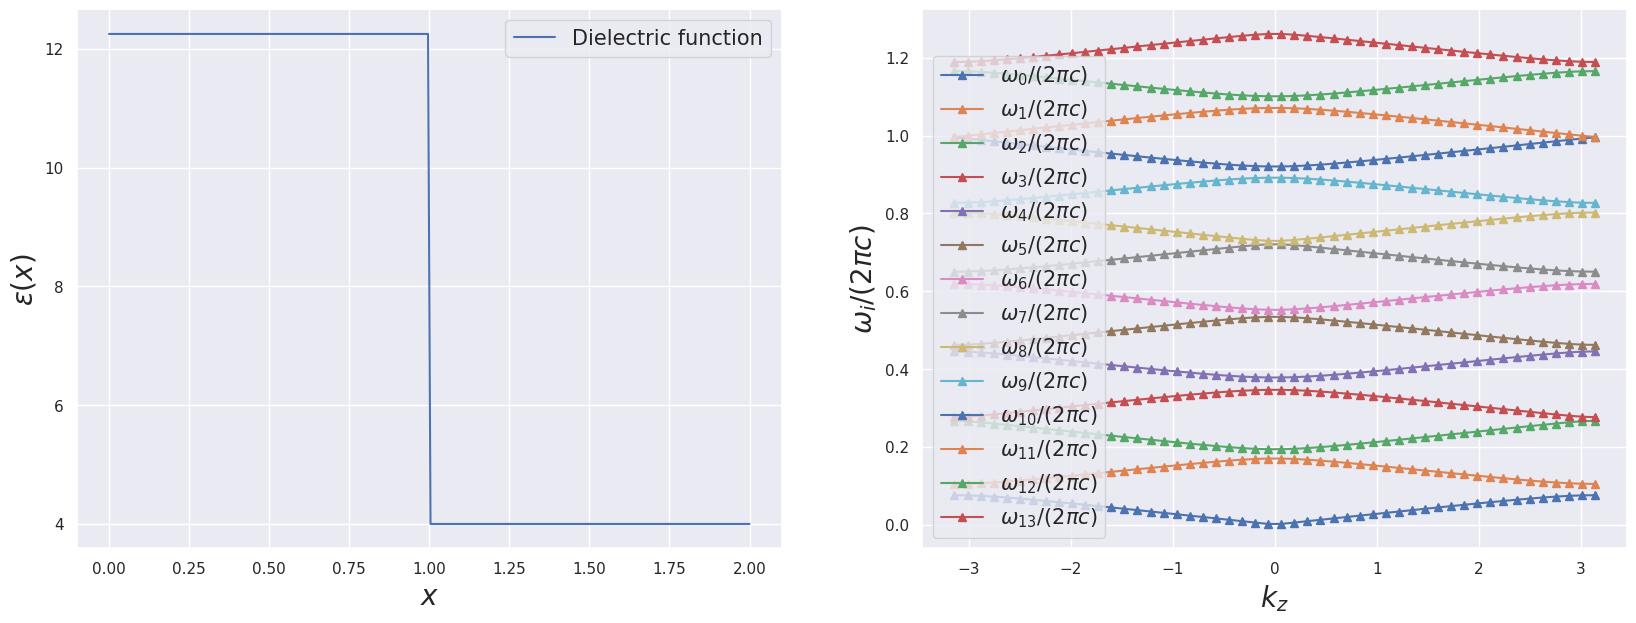

In [100]:
plt.figure(figsize=(20,7))
ks=np.linspace(-np.pi/aa,np.pi/aa,50)
plt.subplot(1,2,1)
plt.plot(x_cell2,e_cell2,label='Dielectric function')
plt.xlabel('$x$',size=20)
plt.ylabel(r'$\epsilon(x)$',size=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
for i in range(0,14):
    plt.plot(ks,freq[i,:]/(2*np.pi),marker='^',label=r'$\omega_{'+str(i)+'}/(2\pi c)$')

plt.xlabel('$k_{z}$',size=20)
plt.ylabel(r'$\omega_{i}/(2\pi c)$',size=20)
plt.legend(fontsize=15)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4'),
  Text(0, 1.6, '1.6')])

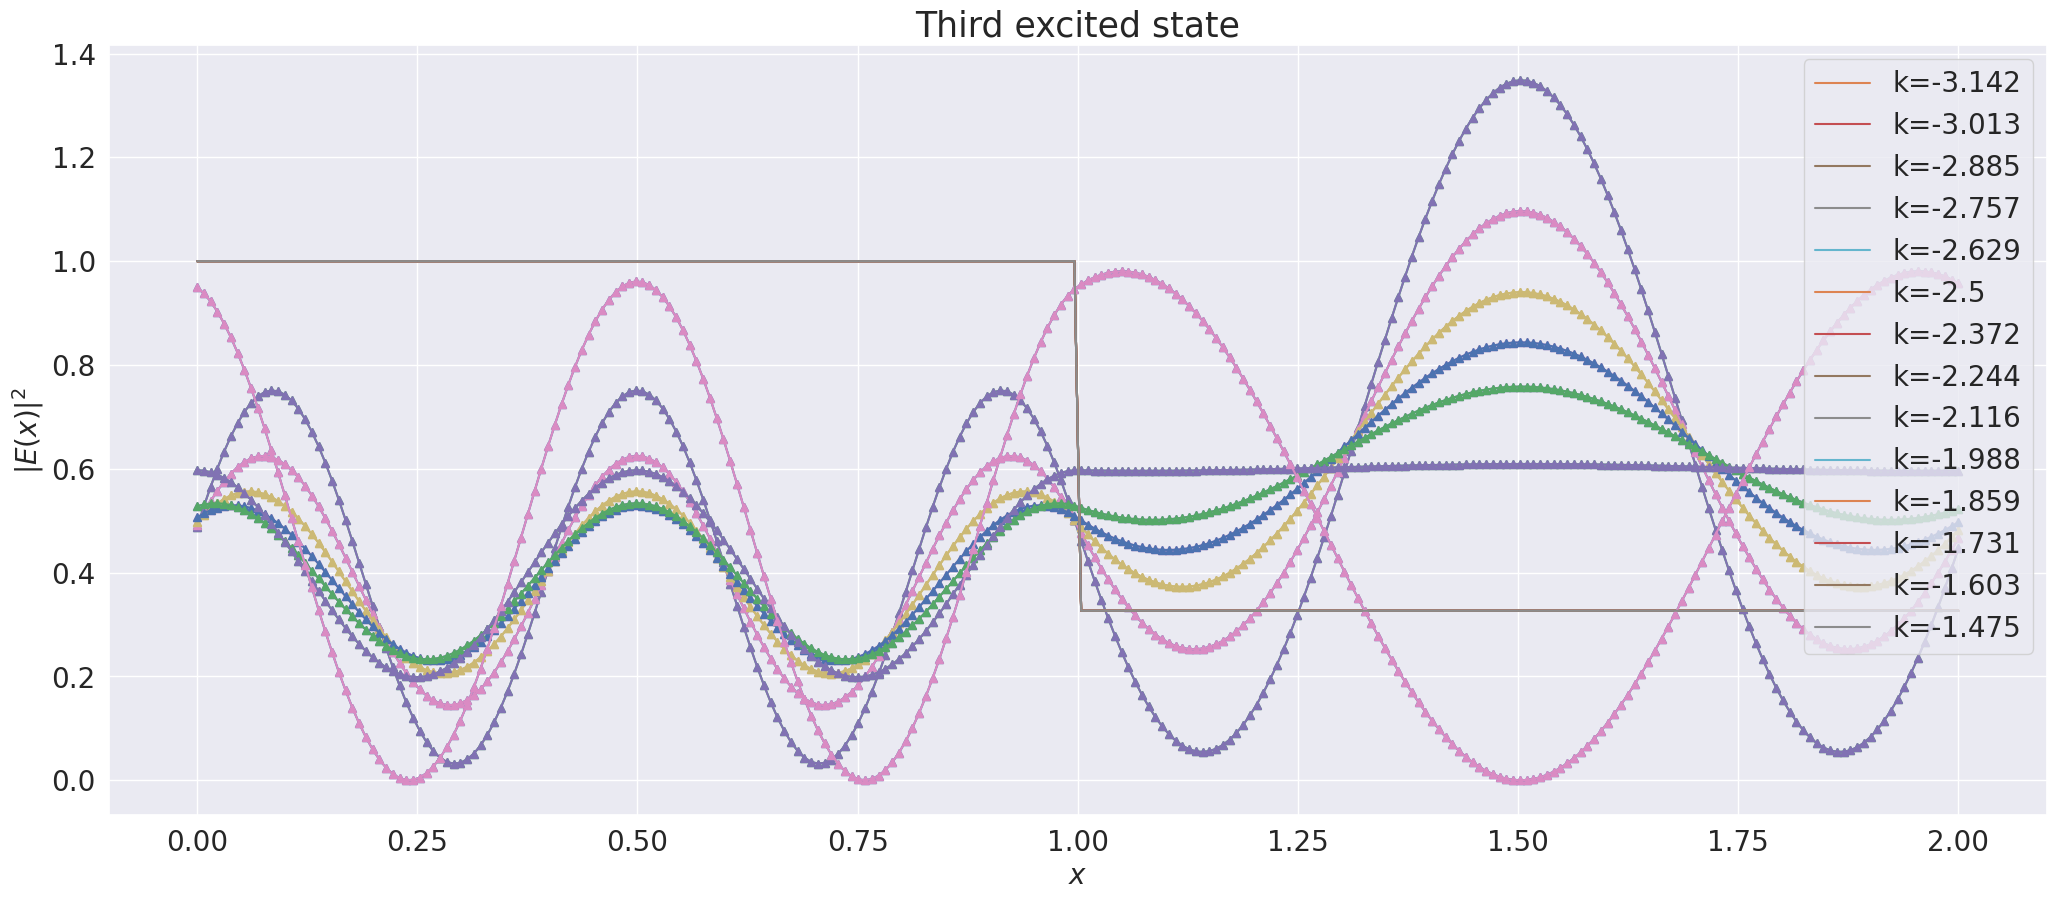

In [110]:
plt.figure(figsize=(25,10))


plt.subplot(111)
for i in range(14):
   
    plt.plot(x_cell2,vects[i,:],marker='^')
    plt.plot(x_cell2,e_cell2/np.max(e_cell2),label='k='+str(round(ks[i],3)))

plt.xlabel('$x$',size=20)
plt.title('Third excited state',fontsize=25)
plt.ylabel(r'$\left | E(x) \right |^{2}$',size=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Recopilación de resultados.

# Ansatz Bloch finito.

$$E(x)=\text{exp}\left( i k x\right)u(x)$$

In [134]:
def finite_1D(xmin, xmax, Nx, Vfun, k, neigs):   # Solucion cristal fotonico finito.
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
   
    H = sparse.eye(Nx, Nx, dtype=complex,format='lil')     # implement the numerical derivative
    e=sparse.eye(Nx, Nx, dtype=complex, format='lil')*(-2)   # implement the numerical derivative
        
    for i in range(Nx - 1):
        H[i, i + 1] =  1
        H[i + 1, i] = 1 
        e[i,i]*=V[i]**-1
    
    H = e@H/ (dx ** 2)


       # convert to csc sparse matrix format:
    H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
    [evl, evt] = sla.eigs(H, k=neigs, which='SM')

    
    for i in range(neigs):
        # normalize the eigenvectors:
        evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
        # eigen values MUST be real:
        evl = np.abs(np.real(evl))
     
    return evl, evt, x

In [15]:
def plot_eigenfunc(xmin, xmax, Nx, Vfun,k, neigs):
    # call the 1D :
    H = finite_1D(xmin, xmax, Nx, Vfun,k, neigs)
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)   
    evt = H[1] # eigenvectors 
    x = H[2] # x grid 
    i = 0
    plt.figure(figsize=(20,15))
    while i < neigs:
        n = indices[i]
        # obtain probabilities from wave functions
        y = np.real(np.conj(evt[:, n]) * evt[:, n]) 
        #y = np.angle( evt[:, n])

        plt.subplot(neigs, 1, i+1)  
        plt.plot(x, y)
        plt.plot(x, Vfun/max(Vfun)*max(y))
        plt.axis('off')
        i = i + 1  
    
    plt.show()
    

In [131]:
def evv_finite(xmin, xmax, Nx, Vfun, neigs,ax):
    ks=np.linspace(-np.pi/ax,np.pi/ax,50)
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
    omega=np.zeros((neigs,len(ks)))
    cc=0
    for k in ks:
        H = sparse.eye(Nx, Nx,dtype=complex, format='lil') * (-2)    # implement the numerical derivative
        e=sparse.eye(Nx, Nx,dtype=complex, format='lil')   # implement the numerical derivative
            
        for i in range(Nx - 1):
            H[i, i + 1] =  1+2*1j*k*dx
            H[i + 1, i] = 1
            H[i , i] = 1+1*1j*k*dx+0.5*dx**2*k**2
            e[i,i]*=V[i]**-1
        
   


        H = e@H/ (dx ** 2)

        # convert to csc sparse matrix format:
        H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
        [evl, evt] = sla.eigs(H, k=neigs, which='SM')

        indices = np.argsort(evl)   
        w=np.sort((np.sqrt(np.abs(evl))))
        for m in range(len(w)):
            omega[m,cc]=w[m]
            
        cc+=1
        print(cc)
    
    return omega


def ev_finite(xmin, xmax, Nx, Vfun,neigs,ax,s):

    ks=np.linspace(-np.pi/ax,np.pi/ax,14)
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size    # Obtain the potential function values:
    V = Vfun  # create the Hamiltonian Operator matrix:
    vect=np.zeros((len(ks),len(x)))
    cc=0
    for k in ks:
        H = sparse.eye(Nx, Nx,dtype=complex, format='lil') * (-2)    # implement the numerical derivative
        e=sparse.eye(Nx, Nx,dtype=complex, format='lil')   # implement the numerical derivative
            
        for i in range(Nx - 1):
            H[i, i + 1] =  1+2*1j*k*dx
            H[i + 1, i] = 1
            H[i , i] = 1+1*1j*k*dx+dx**2*0.5*k**2
            e[i,i]*=V[i]**-1
        
        H[0, -1] =  np.exp(-1j*k*ax)
        H[-1, 0] =  np.exp(1j*k*ax)

        H = e@H/ (dx ** 2)

        # convert to csc sparse matrix format:
        H = H.tocsc()    # obtain neigs solutions from the sparse matrix:
        [evl, evt] = sla.eigs(H, k=neigs, which='SM')
        
        for i in range(neigs):
        # normalize the eigenvectors:
            evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
            
        evl=np.abs(evl)
    
        indices = np.argsort(evl) 
        w=np.sort((np.sqrt(np.abs(evl))))  
        vect[cc,:]=(np.real(np.conj(evt[:, indices[s]]) * evt[:, indices[s]]))
            
        cc+=1


    return vect


        
        

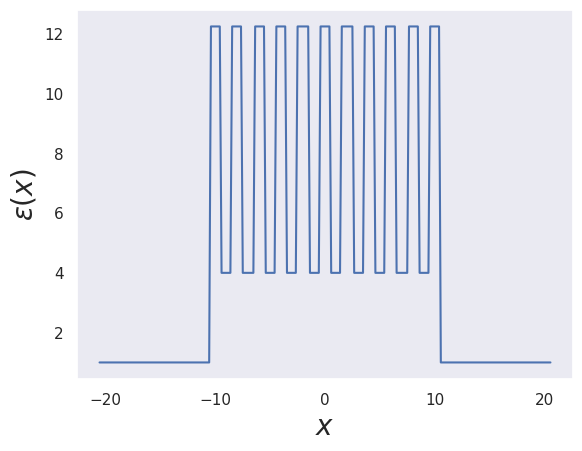

In [132]:
nx = 256 # number of sampling points of a single unit cell
length_aire=10
er2=4  # Dielectric value 2
er1=12.25  # Dielectric value 1
d=1
aa=1 # tamaño de un rectangulo
number=10
L_finite=aa*number+aa/2#  half of the total len of the lattic
ML=int(nx)
Mrest=int(nx)

def periodicf(lid,lfd,f,x):

    
    if x>=lid and x<=lfd :
        return er1
    if ((x>=lfd and x<=(lfd+2*aa)) or (x<=lid and x>=(lid-2*aa))) :
        return f(x)
    if abs(x)>L_finite:
        return 1
    elif x>(lfd+2*aa):
        x_new=x-(2*aa)
        return periodicf(li,lf,f,x_new)
    elif x<(lid-2*aa):
        x_new=x+(2*aa)
        return periodicf(li,lf,f,x_new)
    
    
def squareP(li,lf,x):
    return periodicf(li,lf,square,x)
 
# Non-periodic square wave function defined for a range [-l,l]
def square(x):
    if abs(x)>(lf+aa):
        return er1
    else:
        return er2

li = -d/2
lf = d/2
lon=1
x_cell =np.linspace(-L_finite-length_aire,L_finite+length_aire,ML) # spatial sampling # sampling points in the unit cel
e_cell = [squareP(li,lf,xi) for xi in x_cell]#Dielectric function



plt.plot(x_cell,e_cell)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\epsilon(x)$',fontsize=20)
plt.grid()

In [133]:
freq= evv_infinite(min(x_cell), max(x_cell), nx, np.array(e_cell),14,aa)

ArpackNoConvergence: ARPACK error -1: No convergence (2561 iterations, 13/14 eigenvectors converged)

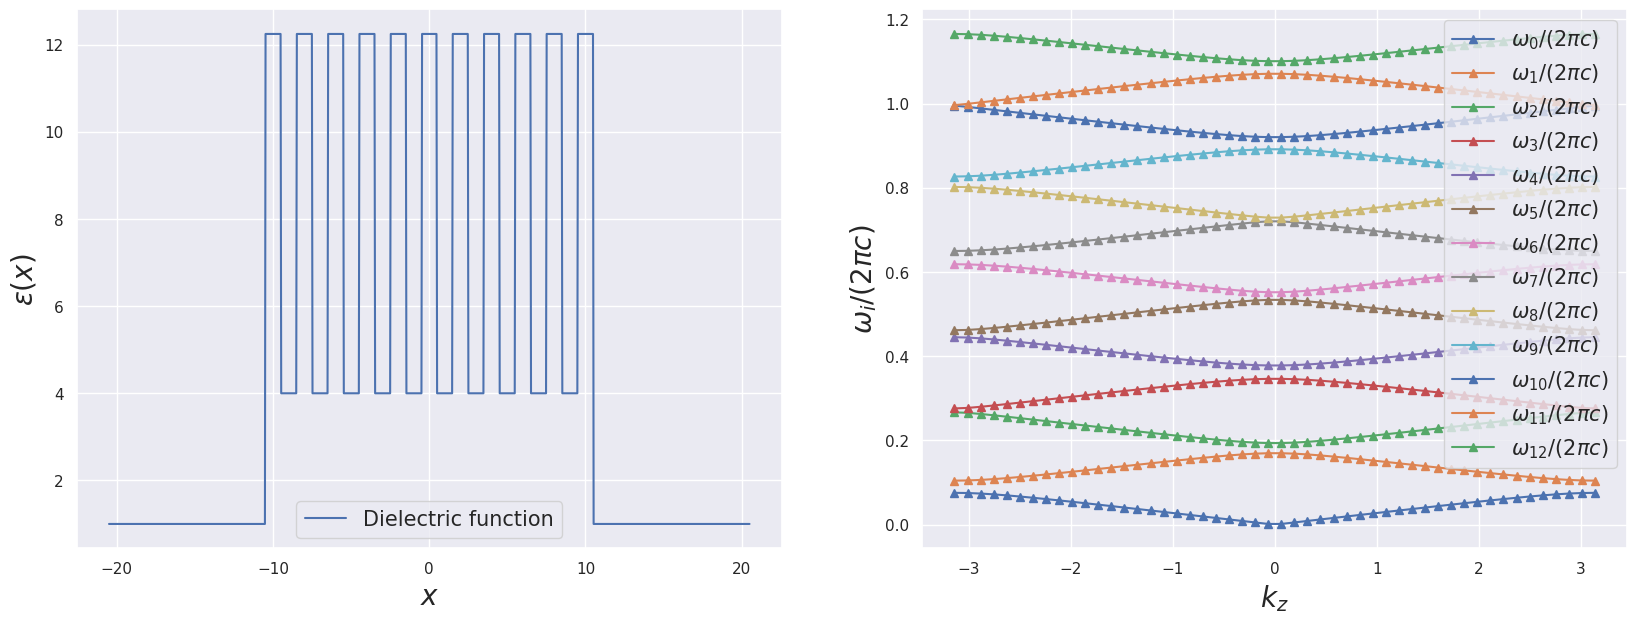

In [116]:
plt.figure(figsize=(20,7))
ks=np.linspace(-np.pi/aa,np.pi/aa,50)
plt.subplot(1,2,1)
plt.plot(x_cell,e_cell,label='Dielectric function')
plt.xlabel('$x$',size=20)
plt.ylabel(r'$\epsilon(x)$',size=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
for i in range(0,13):
    plt.plot(ks,freq[i,:]/(2*np.pi),marker='^',label=r'$\omega_{'+str(i)+'}/(2\pi c)$')

plt.xlabel('$k_{z}$',size=20)
plt.ylabel(r'$\omega_{i}/(2\pi c)$',size=20)
plt.legend(fontsize=15)

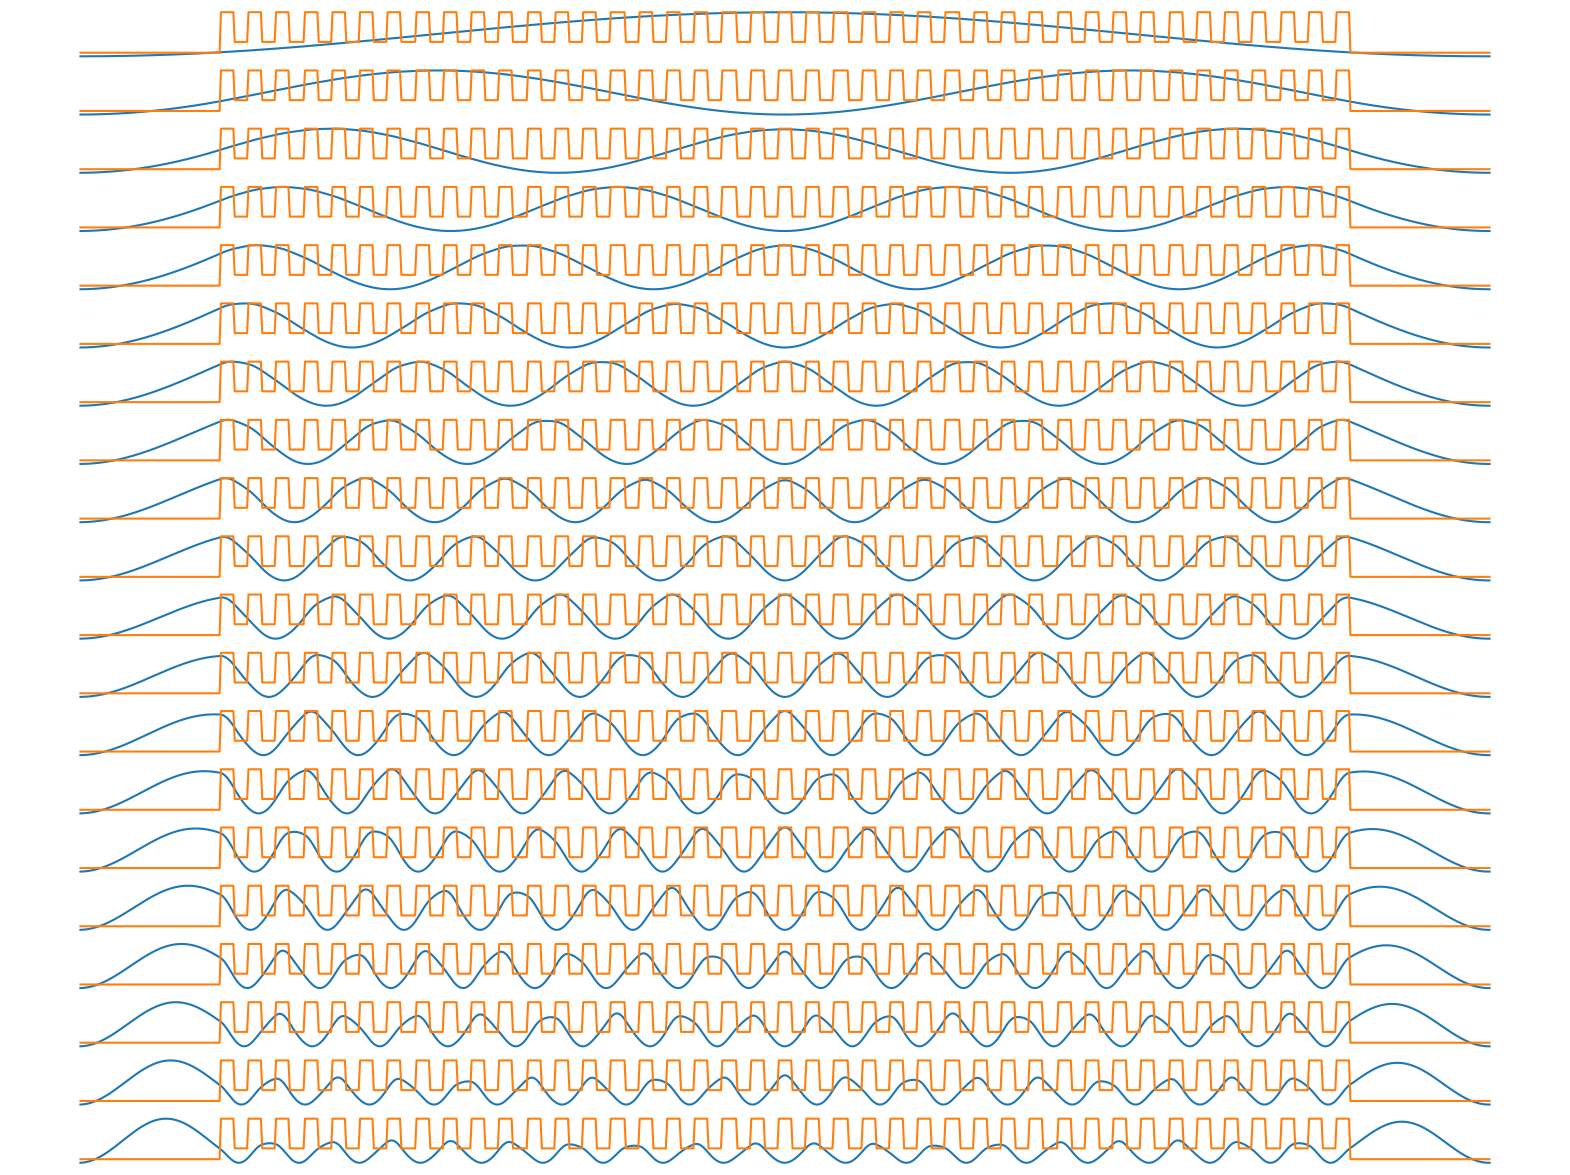

In [17]:
plot_eigenfunc(min(x_cell), max(x_cell), nx, np.array(e_cell),0,20)